# CPD using TIRE

In [91]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences
import warnings
import time, copy

import utils
import TIRE
import simulate

## Set parameters

In [2]:
window_size = 20
domain = "both" #choose from: TD (time domain), FD (frequency domain) or both

#parameters TD
intermediate_dim_TD=0
latent_dim_TD=1 #h^TD in paper
nr_shared_TD=1 #s^TD in paper
K_TD = 2 #as in paper
nr_ae_TD= K_TD+1 #number of parallel AEs = K+1
loss_weight_TD=1 #lambda_TD in paper

#parameters FD
intermediate_dim_FD=10
latent_dim_FD=1 #h^FD in paper
nr_shared_FD=1 #s^FD in paper
K_FD = 2 #as in paper
nr_ae_FD=K_FD+1 #number of parallel AEs = K+1
loss_weight_FD=1 #lambda^FD in paper
nfft = 30 #number of points for DFT
norm_mode = "timeseries" #for calculation of DFT, should the timeseries have mean zero or each window?

## Generate data

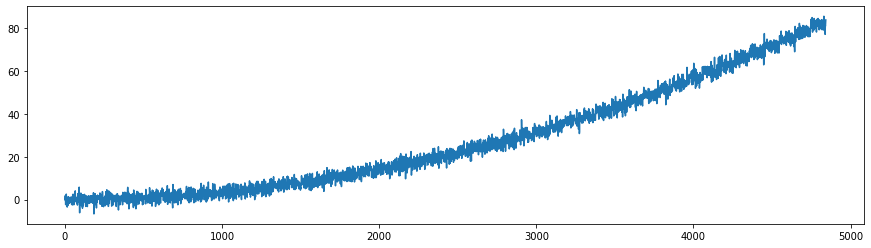

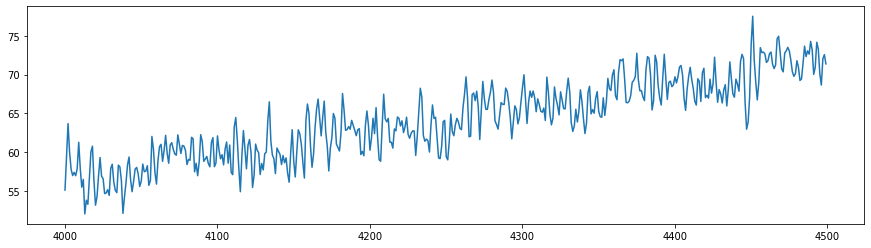

In [37]:

timeseries, windows_TD, parameters = simulate.generate_jumpingmean(window_size)
windows_FD = utils.calc_fft(windows_TD, nfft, norm_mode)

plt.figure(figsize=(15,4))
plt.plot(timeseries)
plt.show()
plt.figure(figsize=(15,4))
plt.plot(range(4000,4500),timeseries[4000:4500])
plt.show()

In [38]:
print(f'parameters: {parameters.shape}, time series shape: {timeseries.shape}')
print(f'windows_TD shape: {windows_TD.shape}, windows_FD shape: {windows_FD.shape}')

parameters: (4843, 1), time series shape: (4843,)
windows_TD shape: (4824, 20), windows_FD shape: (4824, 16)


In [90]:
# import utils
# # parameter is only used for generate groundtruth, so if we can replace by our groundtruth, it's fine
# breakpoints_origin = utils.parameters_to_cps(parameters,window_size) # len(breakpoints) = len(timeseries) = 2*window_size + 1
# print(f'breakpoints shape: {breakpoints_origin.shape}, value: {breakpoints_origin[:10]}')
# breakpoints_index = np.where(breakpoints_origin > 0)[0]

# # len(breakpoints) = len(timeseries) - 2*window_size + 1
# print(f'len: {len(breakpoints_index)}, value: {breakpoints_index}')
# breakpoints = np.array([0] * (len(timeseries) - 2*window_size + 1))

# breakpoints[breakpoints_index] = [1]*len(breakpoints_index)
# assert breakpoints == breakpoints_origin

In [ ]:
# load time series from file 
import json
data_file = './data/quality_control_3.json'
with open(data_file, mode='r') as f:
    data = json.load(f)
    series = data['series']
    timeseries = series[0]['raw']
    timeseries = np.array(timeseries)

In [107]:
# load hasc data 
data_file = './data/preprocess/hasc_l2_norm.csv'
breakpoints_index_file = './data/preprocess/hasc_label_index.txt'

ts_df = pd.read_csv(data_file)
timeseries = ts_df['l2_norm'].to_numpy()

breakpoints_df = pd.read_csv(breakpoints_index_file, header=None)
breakpoints_index = breakpoints_df[0].to_numpy()

In [108]:
timeseries

array([0.99948463, 0.99656462, 1.00259002, ..., 1.02847954, 1.04353318,
       1.03048233])

In [109]:
breakpoints_index

array([ 3959,  5305,  7812, 10325, 10565, 13084, 14136, 14184, 14411,
       14931, 18428, 19901, 21086, 21538, 23834, 24236, 24469, 24818,
       24884, 25214, 25597, 25710, 25780, 26510, 27408, 27431, 28116,
       28396, 29188, 30016, 30072, 30407, 30769, 30858, 33567, 34033,
       34265, 35529, 37511, 37787])

In [110]:


'''
1. Generate time series, 
2. convert time series into window_TD
3. Convert time serites into window_FD
4. Create groundtruth
'''
windows_TD = utils.ts_to_windows(timeseries, 0, window_size, 1)
windows_TD = utils.minmaxscale(windows_TD,-1,1)
windows_FD = utils.calc_fft(windows_TD, nfft, norm_mode)

# len(breakpoints) = len(timeseries) - 2*window_size + 1
# breakpoints_index = [179]
print(f'len: {len(breakpoints_index)}, value: {breakpoints_index}')
breakpoints = np.array([0] * (len(timeseries) - 2*window_size + 1))

breakpoints[breakpoints_index] = [1]*len(breakpoints_index)
print(len(timeseries), len(breakpoints))

len: 40, value: [ 3959  5305  7812 10325 10565 13084 14136 14184 14411 14931 18428 19901
 21086 21538 23834 24236 24469 24818 24884 25214 25597 25710 25780 26510
 27408 27431 28116 28396 29188 30016 30072 30407 30769 30858 33567 34033
 34265 35529 37511 37787]
39397 39358


## Train the autoencoders

In [112]:
shared_features_TD = TIRE.train_AE(windows_TD, intermediate_dim_TD, latent_dim_TD, nr_shared_TD, nr_ae_TD, loss_weight_TD, nr_patience=10)
shared_features_FD = TIRE.train_AE(windows_FD, intermediate_dim_FD, latent_dim_FD, nr_shared_FD, nr_ae_FD, loss_weight_FD, nr_patience=10)

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 3, 20)]      0           []                               
                                                                                                  
 dense_35 (Dense)               (None, 3, 1)         21          ['input_19[0][0]']               
                                                                                                  
 dense_36 (Dense)               (None, 3, 0)         0           ['input_19[0][0]']               
                                                                                                  
 tf.concat_9 (TFOpLambda)       (None, 3, 1)         0           ['dense_35[0][0]',               
                                                                  'dense_36[0][0]']        

## Postprocessing and peak detection

In [113]:
#we calculate the smoothened dissimilarity measure and the corresponding prominence-based change point scores
from importlib import reload 
reload(TIRE)
print(f'shared_features_TD shape: {shared_features_TD.shape}')
dissimilarities = TIRE.smoothened_dissimilarity_measures(shared_features_TD, shared_features_FD, domain, window_size)
change_point_scores = TIRE.change_point_score(dissimilarities, window_size)

shared_features_TD shape: (39378, 1)
encoded_windows_both shape before: (39378, 2)
encoded_windows_both shape: (39378, 2)
distances shape: (39358,)
distances shape filter: (39358,)


In [123]:
np.where(change_point_scores > 0.1)

(array([ 3611,  3685,  3974,  4383,  4813,  4969,  5063,  5113,  5232,
         5698,  5796,  5900,  6000,  6105,  6205,  6304,  6408,  6508,
         6614,  6724,  6933,  7031,  7125,  7543, 10570, 10658, 10767,
        10990, 11054, 11095, 11346, 11455, 11659, 11762, 11865, 11970,
        12039, 12597, 12870, 13090, 13217, 13329, 13448, 13564, 13687,
        13822, 13893, 13994, 14073, 14172, 14423, 14610, 15013, 15314,
        15419, 15518, 15829, 16127, 16326, 16456, 16519, 16719, 17058,
        17155, 17247, 17342, 17446, 17602, 17696, 17923, 18022, 18265,
        19900, 19986, 20023, 20099, 20139, 20248, 20322, 20432, 20540,
        20650, 20758, 20978, 21547, 21625, 22010, 22197, 22526, 22623,
        22722, 22868, 23097, 23190, 23382, 23434, 23581, 23762, 23817,
        23913, 24009, 24102, 24467, 24710, 24788, 25216, 25299, 25406,
        25447, 25712, 25794, 25916, 26025, 26182, 26510, 26618, 26715,
        26818, 26911, 27166, 27315, 27584, 27688, 27794, 27895, 28000,
      

In [115]:
print(f'change point scores. shape: {change_point_scores.shape}, head 20: {change_point_scores[:20]}')

change point scores. shape: (39397,), head 20: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [116]:
np.savetxt("change_point_scores.txt", change_point_scores)

In [120]:
np.where(breakpoints > 0)[0]

array([ 3959,  5305,  7812, 10325, 10565, 13084, 14136, 14184, 14411,
       14931, 18428, 19901, 21086, 21538, 23834, 24236, 24469, 24818,
       24884, 25214, 25597, 25710, 25780, 26510, 27408, 27431, 28116,
       28396, 29188, 30016, 30072, 30407, 30769, 30858, 33567, 34033,
       34265, 35529, 37511, 37787])

In [124]:
np.where(breakpoints > 0)

(array([ 3959,  5305,  7812, 10325, 10565, 13084, 14136, 14184, 14411,
        14931, 18428, 19901, 21086, 21538, 23834, 24236, 24469, 24818,
        24884, 25214, 25597, 25710, 25780, 26510, 27408, 27431, 28116,
        28396, 29188, 30016, 30072, 30407, 30769, 30858, 33567, 34033,
        34265, 35529, 37511, 37787]),)

In [126]:
np.where(dissimilarities > 0.001)

(array([  341,   342,   343, ..., 39326, 39327, 39328]),)

In [128]:
np.array(range(21))/ 20

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

CHANGED !!!!!!!!!!!!!!!!!!!
peaks prom all. shape: (39358,), values: [0. 0. 0. 0.]


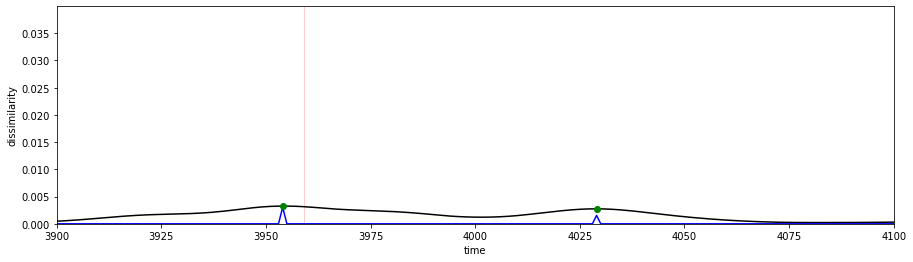

quantiles: [0.0, 1.3605909987644133e-08, 1.9661154622198255e-06, 6.6795931733977845e-06, 1.4727264291442862e-05, 2.614115237557834e-05, 4.2302614117884064e-05, 6.508083419214908e-05, 0.00010860291417891821, 0.00017301441888352794, 0.0002763647969370005, 0.0004077647174219705, 0.0005821082909628455, 0.0008449006412552193, 0.0010934779049484858, 0.0015477943308276666, 0.0020054662886792975, 0.002564947812294027, 0.0030563862828567275, 0.004000152232300815, 0.005954866604892526, 0.0266219587829751]
ncr: [48.  7.  7.  6.  5.  5.  4.  4.  4.  4.  4.  4.  3.  2.  0.  0.  0.  0.
  0.  0.  0.  0.]
nal: [39358   812   771   730   690   649   609   568   528   487   447   406
   365   325   284   244   203   163   122    82    41     1]
quantiles: [0.0, 1.3605909987644133e-08, 1.9661154622198255e-06, 6.6795931733977845e-06, 1.4727264291442862e-05, 2.614115237557834e-05, 4.2302614117884064e-05, 6.508083419214908e-05, 0.00010860291417891821, 0.00017301441888352794, 0.0002763647969370005, 0.0004077

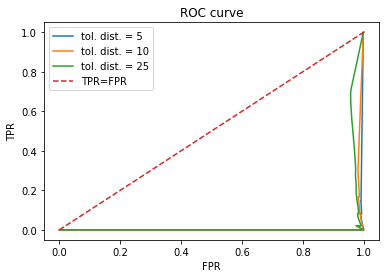

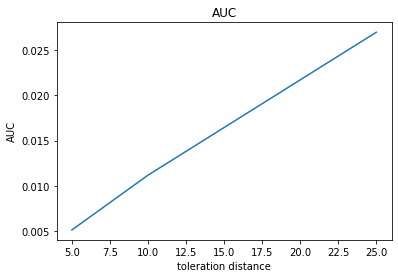

In [129]:
#parameters for plot
# import utils
from importlib import reload 
reload(utils)
time_start = 3900
time_stop = 4100
plot_prominences = True
'''
- green point: peak point based on simple comparasion with neighbour point (use scipy.signal)
- black line: disimilarity curve 
- vertical red line: groundtruth. But in this graph, it only use for the sake of example
- vertical blue: peak prominence (use scipy.singal)
'''

utils.plot_cp(dissimilarities, parameters, window_size, time_start, time_stop, plot_prominences, breakpoints)

#parameters for AUC calculation
tol_distances = [5,10,25]
auc = utils.get_auc(dissimilarities,tol_distances, parameters, window_size, breakpoints)